In [1]:
import sys 
sys.path.append("C:\\Users\\smoot\\Desktop\\Stage Mnemosyne")

In [2]:
#Importation des différentes fonctions qui servent dans ce script

import functions.functions_data as d
import functions.functions_affichage as a
import functions.functions_cocleogramme as c
from functions.ReccurentNetwork import RecurrentNetwork

from random import randint

from IPython.display import clear_output

from reservoirpy.nodes import Reservoir,FORCE,Ridge
from reservoirpy.mat_gen import Initializer,_scale_spectral_radius,normal
from reservoirpy.observables import spectral_radius
from tqdm import tqdm

from ReccurentNetwork import *

import numpy as np
import copy
from numpy.linalg import eig

import spicy as sp
import matplotlib.pyplot as plt


In [3]:
#Code importé de ReservoirPy
def _rls(P, x, e):
    """Recursive Least Squares learning rule."""
    k = np.dot(P, x)
    xPx = np.dot(x.T, k)
    c = float(1.0 / (1.0 + xPx))
    P = P - c * np.outer(k, k)
    dw = -c * np.outer(e, k)

    return dw, P

# Réseaux de neurones

On cherche ici dans un premier temps à reprdoduire les figures les plus simples de l'article. 

Les mesures de l'article sont effectuées sur 2 réservoirs $ : 

  - le premier est dit entrainé : on va alors entrainer le réservoir et la sortie
  - le second lui est dit non entrainé : on entraine seulement la sortie
    

Ce premier script s'intéresse donc à la reproduction de l'entrainement des figures 3, 4 et 5 ainsi qu'aux résultas obtenus sur un réservoir entrainé.


## Expériences

Deux expériences quasiment similaires sont proposés pour un réservoir totalement entrainé. La seule différence entre ces dernières sont le nombre de neurones utilisés dans le réservoir : 

   - Soit N = 2100 pour des résultats robustes entre toutes les données pour un sujet
   - Soit N = 4000 pour des résultats robustes entre tous les sujets (5 au maximum)
    
Nous traiterons le premier  cas dans ce papier.

##### Méthode d'entrainement

Pour ce qui est de l'entrainement du réservoir nous allons procéder comme ceci : nous séparons notre entrée en deux parties : l'époque sensorielle et l'époque motricielle. 

###### Epoque sensorielle : 

Pour un sujet donné et parmit toutes les entrées différentes, pour chaque chiffre on selectionne une entrée moyenne. Cette entrée est injectée dans le réservoir sans bruit et sans target, on obtient alors une trajectoire resultante de taille (Timesteps x Nombre de neurones) pour chaque chiffre. Ces 10 trajectoires sont appelées les "innate trajectories" et seront les targets pour toutes les autres entrées durant l'entrainement du l'époque sensorielle en faisant bien attention à  ce que la dimension d'entrée des nouvelles entrées soit cohérente avec celle de l'innate trajectorie, on procédera alors pas une déformation linéaire de l'innate trajectory. De plus, du bruit sera présent durant l'entrainement.

###### Epoque motrice

On met dans le réservoir une matrice nulle (entrée à 0) et la target de l'époque motrice est l'activité autonome générée par le réservoir sur une durée comprenant la transition époque sensorielle/motrice et l'époque motrice.
Pour récupérer notre matrice, on utilisera la fonction target_xyz avec comme paramètre, innate = True 

##### Entrainement

On concatene maintenant l'innate trajectory de l'époque sensorielle et de l'époque motrice pour obtenir nos targets finales.

À noter, que chaque entrainement et test commence à -100ms avec le réseau initialisé selon une loi uniform de -1 à 1.
--> On laisse tourner le réservoir pendant 100ms à blanc ouis on met les entrées ????


###### Test
Les test effectués dans ce script seront fait sur le sujet 1

Données générales 

In [4]:
data = d.extract_data() #Données d'entrée
transcription = d.extract_target() #Données d'arrivée 

#Les données suivantes sont utilisés dans les fonctions mais pas dans le script ! 

freq_ent = 6*10**3  #fréquence d'entrée
T_ent = 1/freq_ent  #période d'entrée

freq_out = 10**3 #fréquence de sortie 
T_out = 1/freq_out #période de sortie

ampl_int = 5 #Amplitude d'entrée

Données du réservoir

In [5]:
N = 2100//7 #Nombre de neurones dans le réservoir
M = 12 #Nombres d'entrées
No = 3 #Nombres de sorties
tau = 25*10e-3
dt = 1e-3
lr = dt/tau
sr = 1.6 #spectral radius --> gain ?
g = 1.6 #le gain du réseau ?                             #je comprends pas trop cette donnée. 
pc = 0.2 # connectivité entre les neurones (pc dans l'article)
SD = g/np.sqrt(pc*N)
mu = 0
I0 = 0.005 

Wout = normal(No,N,loc=mu,scale = 1/np.sqrt(N))    #Matrice de sortie


In [6]:
np.shape(Wout)

(3, 300)

Création de la matrice du réservoir : avec pas d'autapse
Puis bricolage pour réxupérer le rayon spectral voulu

In [7]:
c.W_r.init = Initializer(c.W_r)

W = _scale_spectral_radius(c.W_r.init, [N,N], sr)
W = W.toarray()

Création de la matrice d'entrée : chaque entrée k est projetée sur le neurone $(k-1)\frac{N}{M} + 1$ jusqu'au neurone $k\frac{N}{M}$ selon une loi normale 

In [8]:
Win = c.W_in(N,M)

Création des réservoirs

In [9]:
#Réservoir que l'on va entrainer
W_reservoir = copy.deepcopy(W)
reservoir_train = Reservoir(W=W_reservoir,Win=Win,equation='external',input_bias=False)

#Réservoir que l'on ne va pas entrainer 
reservoir_innate = reservoir_train.copy()

# Trajectoire inée 

Récupération des cocleograms avec une taille maximale pour chaque chiffre 

In [10]:
#Liste qui va contenir tout les cocleogramme maximums pour chaque chiffre
max_cocleogram =[]

for i in range(10):
    
    #Récupération des indices du cocléogramme le plus grand du chiffre i
    indS,indU,indD = c.ind_max_entrance(i,data)
    
    #Ajout à la liste
    max_cocleogram.append(c.entrance_cocleogram(indS,indS,indD,data,transcription).T)

Détermination des trajectoires inées  

In [11]:
#Liste qui va contenir toutes les trajectoires innées
innate_trajectories = []

for i in range(len(max_cocleogram)):
    
    #Récupération des trajectoires innées 
    initial_trajectory = reservoir_innate.run(max_cocleogram[i])
    
    #Ensuite on les ajoute
    innate_trajectories.append(initial_trajectory)

clear_output()

Activité de quelques neurones du réservoir sur les trajectoires innées

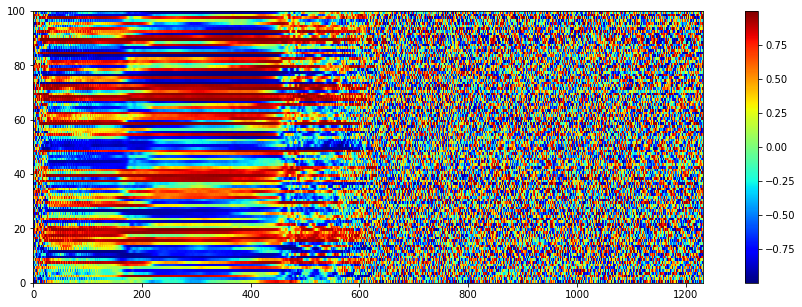

In [12]:
fig, ax = plt.subplots(figsize=(15,5))
im = ax.pcolormesh(innate_trajectories[1][:,:100].T,cmap="jet")
fig.colorbar(im,ax = ax)

# Entrainement du réservoir 

Maintenant que les targets pour les différentes époques sont prêtes, il va falloir concaténer le tout. Donc pour chaque entrée, on va d'abord déformer linéairement la trajectoire innée de l'époque sensorielle, puis, on va ajouter la target de l'époque motrice en concaténant les matrices

In [13]:
X_input = []
X_target = []
for indS in [1,1,1] : 
    for indU in range(1,4):
        for indD in range(10):
            #Ajout de l'input
            X_input.append(np.transpose(c.entrance_cocleogram(indS, indU, indD,data,transcription)))
            
            #Récupération de la target
            target = innate_trajectories[indD] 

            #Concaténation et ajout dans la target
            X_target.append(target)

# ReservoirPy

Définition des valeurs qui vont me servir. Et, dans l'article, seulement 90% des connexions sont modifiées, je définis alors les indices qui ne seront pas modifés

In [14]:
#Matrice de gain
P = np.identity(N)

#Matrice de 0, permet de faire tourner le réservoir pendant 100 ms 
blanc = np.zeros((100,12))


#Nombre de connexion qui ne devront pas changer
nbr = int(N*0.1)

#Les indices des connexions qui ne changeront pas 
indice_rows = [randint(0,N-1) for i in range(nbr)]
indice_cols = [randint(0,N-1) for i in range(nbr)]

On laisse d'abord tourner le réservoir pendant 100ms (avec une période de 1ms), et on récupère l'état des neurones pour l'injecter dans un réservoir et commencer notre entrainement.

90it [04:29,  2.99s/it]

entrainement 90, moyenne :0.005536301160363529


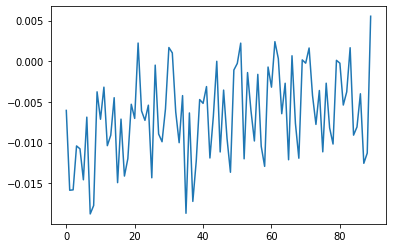

In [15]:
compt = 0
error_total = []
for xi,xt in tqdm(zip(X_input,X_target)):
    
    #On laisse d'abord le réservoir tourner à vide pendant 100 ms
    Test = reservoir_train.run(blanc)
    
    #Ensuite on l'entraine
    
    #On calcul la sortie du réservoir pour une entrée xi est on obtient la matrice x1
    x1 = reservoir_train.run(xi)
    
    #On calcul l'erreur entre la sortie du réservoir x1 et la valeur cible xt
    e = x1-xt
    
    #Et pour chaque pas de temps, on va modifier la matrice 
    for t in range(len(x1)):
        
        #Calcul de la variation de W et de la matrice de gain
        dW, P = _rls(P,x1[t],e[t])
        
        #On enlève 10% des changements
        for r,col in zip(indice_rows,indice_cols):
            dW[r,col] = 0
        
        #On enleve les poids réccurents (car des valeurs trop grandes)
        for k in range(N):
            dW[k,k] = 0
        
        #On modifie W
        W_reservoir += dW
        
    #On injecte W dans le réservoir pour les nouveux calculs
    reservoir_train.set_param("W",W_reservoir)

    clear_output()
    
    compt += 1
    
    error_total.append(np.mean(e))
    
    print("entrainement {}, moyenne :{}".format(compt,np.mean(e)))

#Affichage de l'évolution des valeurs de l'erreur : 
plt.plot(error_total)

Affichage des valeurs propores :

C:\Users\smoot\Desktop\Stage Mnemosyne\functions\functions_affichage.py:270: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


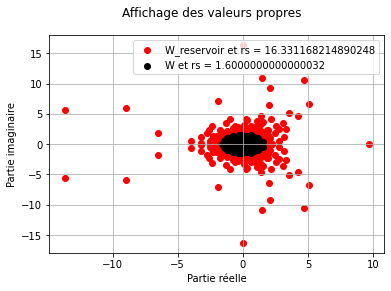

In [16]:
a.eigein_value(W_reservoir,W,"W_reservoir","W")

Réservoir après training :

Running Reservoir-1: 100%|███████████████████████████████████████████████████████| 2040/2040 [00:00<00:00, 5781.24it/s]


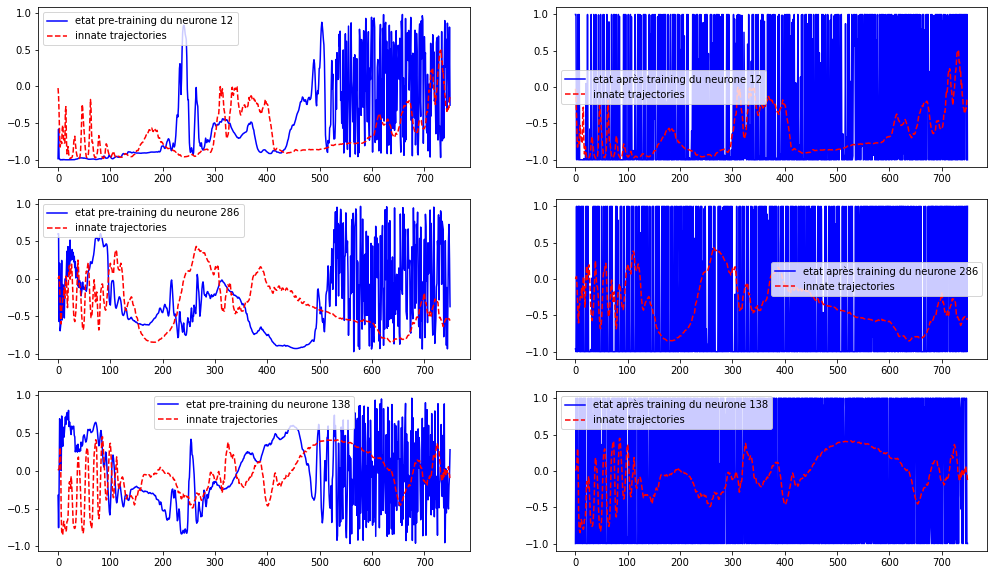

In [17]:
X_test = X_input[0]

X_pred_training = reservoir_train.run(X_test)
X_pred_pre_training = reservoir_innate.run(X_test)

target = X_target[0]

fig,ax = plt.subplots(figsize=(17,10),nrows = 3,ncols=2)

for i in range(3):
    neuron = randint(1,N)
    ax[i,0].plot(X_pred_pre_training[:750,neuron],"b",label = "etat pre-training du neurone " + str(neuron))
    ax[i,0].plot(target[:750,neuron],'--r',label = "innate trajectories")
    ax[i,0].legend()
    
    ax[i,1].plot(X_pred_training[:750,neuron],"b",label = "etat après training du neurone " + str(neuron))
    ax[i,1].plot(target[:750,neuron],'--r',label = "innate trajectories")
    ax[i,1].legend()

Le réservoir est totalement saturé 

Affichage de la matrice

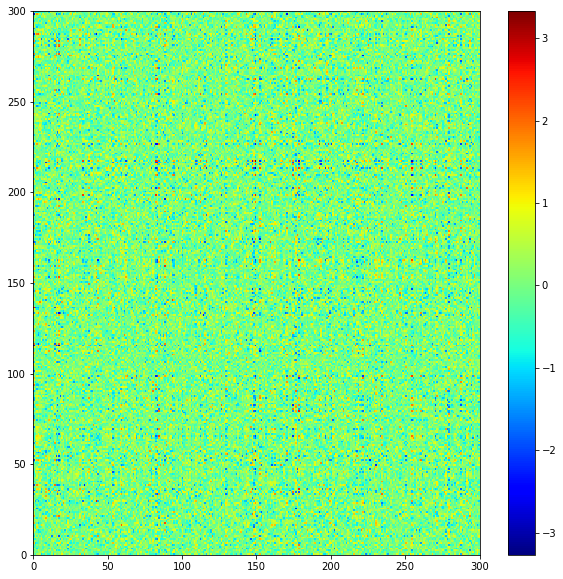

In [18]:
fig, ax0= plt.subplots(figsize=(10,10))

im = ax0.pcolormesh(W_reservoir, cmap="jet",)
fig.colorbar(im, ax=ax0)


# Entrainement de la sortie

Création des données d'entrainement

In [19]:
X_input = []
X_target = []
for indS in [1] : 
    for indU in range(1,4):
        for indD in range(10):
            #ajout de l'input
            X_input.append(np.transpose(c.entrance_cocleogram(indS, indU, indD,data,transcription)))
            
            #ajout de la target
            X_target.append(c.target_xyz(indS, indU, indD,data,transcription))

On crée le modèle

In [20]:
#Création des différents noeuds
readout_train = FORCE()

#Création du modèle complet
model = reservoir_train >> readout_train

Ensuite on entraine la sortie, normalement, chaque entrée est entrainée 25 fois

In [21]:
#Matrice vide
blanc = np.zeros((100,12))

#récupération des données 1 à 1
for xi,xt in tqdm(zip(X_input,X_target)):
    
    #nombre de fois qu'on entraine une entrée 
    nbr_training = 1
    
    for nbr in range(nbr_training):
        
        #On fait d'abord tourner le réservoir à vide
        reservoir_train.run(blanc)
        
        #Entrainement avec le noeud force : méthode online 
        model.train(xi,xt,reset = True)

        
    clear_output()

30it [01:45,  3.51s/it]


Une fois le réservoir entrainé, on le test sur 1 chiffre avec tout les détails.

In [22]:
#Test du réservoir

#Récupération d'un cocléogramme utilisé durant l'entrainement
indS,indU,indD = 1,3,6
X_test = np.transpose(c.entrance_cocleogram(indS,indU,indD,data,transcription))

#On fait tourner le réservoir
X_pred = model.run(X_test)
    
#récupération des états des neurones
states = c.etat(reservoir_train,indS,indU,indD,data,transcription,1)

#récupération de l'erreur commise sur la trajectoire d'un chiffre
erreur= c.error(X_pred,indS,indU,indD,data,transcription)


Running Model-0: 2516it [00:00, 3505.21it/s]                                                                           
Running Reservoir-0: 100%|███████████████████████████████████████████████████████| 2516/2516 [00:00<00:00, 5692.38it/s]


Affichage des résultats

1


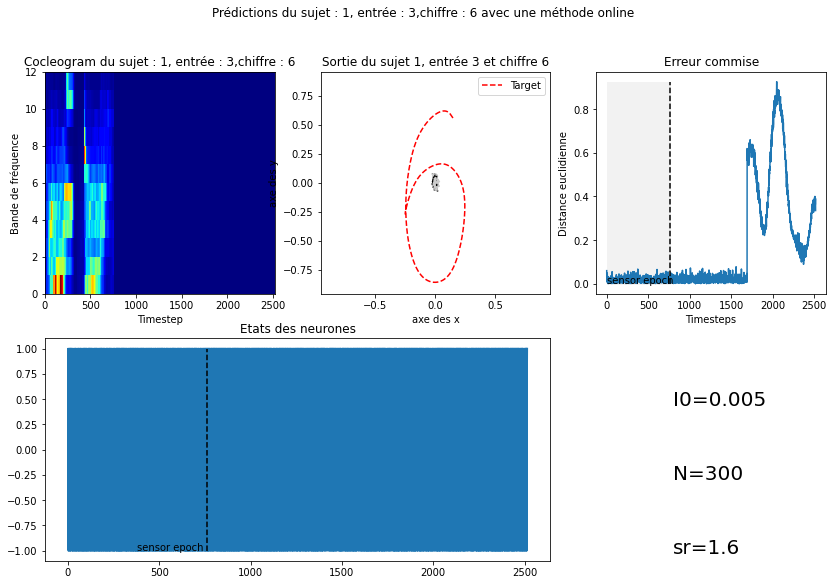

In [23]:
a.affiche(X_pred,indS,indU,indD,data,transcription,states,erreur,mode = "online",sr = sr,N=N,I0 = I0)

Ensuite on le test sur les 10 chiffres du même sujet et sur la même entrée

In [24]:
#Récupération de l'entrée et du sujet
indS,indU= 1,3

chiffre_pred=[]

#On calcule la prédictions pour chacun des 10 chiffres 
for i in range(10):
    
    #Récupération de l'entrée
    X_test = np.transpose(c.entrance_cocleogram(indS,indU,i,data,transcription))
    
    #On fait tourner le réservoir
    chiffre_pred.append(model.run(X_test))


Running Model-0: 2040it [00:00, 2838.36it/s]                                                                           
Running Model-0: 1231it [00:00, 2650.06it/s]                                                                           
Running Model-0: 1680it [00:00, 2822.66it/s]                                                                           
Running Model-0: 2076it [00:00, 2851.24it/s]                                                                           
Running Model-0: 1602it [00:00, 2933.97it/s]                                                                           
Running Model-0: 2311it [00:00, 2900.75it/s]                                                                           
Running Model-0: 2516it [00:00, 3162.40it/s]                                                                           
Running Model-0: 1903it [00:00, 2800.05it/s]                                                                           
Running Model-0: 1990it [00:00, 2984.81i

Puis on affiche notre résultat

C:\Users\smoot\Desktop\Stage Mnemosyne\functions\functions_affichage.py:225: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


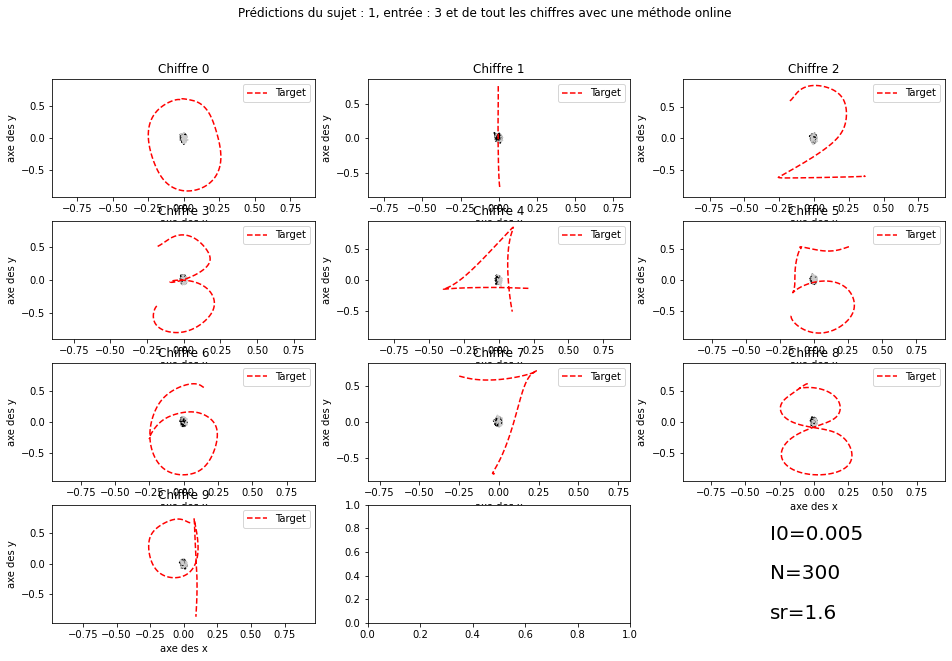

In [25]:
a.affiche_chiffre(chiffre_pred,indS,indU,data,transcription,mode="online",sr = sr,N=N,I0 = I0)

### Test RLS avec code de Vitay

Problème :
  - déformation linéaire : ça met les valeurs de mes trajectoires innées au dessus de un et en dessous de -1 
  - entrainement du RLS s'arrete quand l'erreur tend asymptotiquement vers une valeur 

In [27]:
####################
# Create the network
####################

W_rec = copy.deepcopy(W)

net = RecurrentNetwork(
    W_in = Win,
    W_rec = W_rec,
    W_out = Wout,
    Ni = M, # Number of inputs
    N = N, # Number of recurrent neurons
    No = No, # Number of read-out neurons
    tau = 25.0, # Time constant of the neurons
    g = 1.6, # Synaptic strength scaling
    pc = 0.2, # Connection probability
    Io = 0.05, # Noise variance
    delta = 10.0, # Initial diagonal value of the P matrix
    P_plastic = 0.9, # Percentage of neurons receiving plastic synapses
)

In [ ]:
W = np.array

In [28]:
####################
# Coordonnées innées
####################

#Liste qui va contenir toutes les trajectoires innées
innate_trajectories = []

for i in range(len(max_cocleogram)):
    
    #Récupération des trajectoires innées 
    stimulus = np.expand_dims(max_cocleogram[i],axis =2)
    initial_trajectory, _, = net.simulate(stimulus = stimulus, noise = False)
    
    #Ensuite on les ajoute
    innate_trajectories.append(initial_trajectory)

clear_output()

7


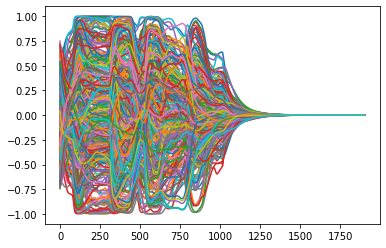

In [29]:
alea = randint(0,9)
affichage_innate = np.squeeze(innate_trajectories[alea],axis =2)
plt.plot(affichage_innate)
clear_output()
print(alea)

In [30]:
####################
# Données entrainement
####################

X_input_rc = []
X_target_rc = []
for indS in [1] : 
    for indU in range(1,4):
        for indD in range(10):
            #Récupération de l'Input
            Input = np.expand_dims(c.entrance_cocleogram(indS, indU, indD,data,transcription).T,axis =2)
            
            #Ajout
            X_input_rc.append(Input)
            
            #Récupération de la target
            target = innate_trajectories[indD] 

            #Ajout dans la target
            X_target_rc.append(target)
            
            print(np.shape(Input),np.shape(target))
            

(2040, 12, 1) (2040, 300, 1)
(1231, 12, 1) (1231, 300, 1)
(1680, 12, 1) (1680, 300, 1)
(2076, 12, 1) (2076, 300, 1)
(1602, 12, 1) (1602, 300, 1)
(2311, 12, 1) (2311, 300, 1)
(2516, 12, 1) (2516, 300, 1)
(1903, 12, 1) (1903, 300, 1)
(1990, 12, 1) (1990, 300, 1)
(2175, 12, 1) (2175, 300, 1)
(2040, 12, 1) (2040, 300, 1)
(1231, 12, 1) (1231, 300, 1)
(1680, 12, 1) (1680, 300, 1)
(2076, 12, 1) (2076, 300, 1)
(1602, 12, 1) (1602, 300, 1)
(2311, 12, 1) (2311, 300, 1)
(2516, 12, 1) (2516, 300, 1)
(1903, 12, 1) (1903, 300, 1)
(1990, 12, 1) (1990, 300, 1)
(2175, 12, 1) (2175, 300, 1)
(2040, 12, 1) (2040, 300, 1)
(1231, 12, 1) (1231, 300, 1)
(1680, 12, 1) (1680, 300, 1)
(2076, 12, 1) (2076, 300, 1)
(1602, 12, 1) (1602, 300, 1)
(2311, 12, 1) (2311, 300, 1)
(2516, 12, 1) (2516, 300, 1)
(1903, 12, 1) (1903, 300, 1)
(1990, 12, 1) (1990, 300, 1)
(2175, 12, 1) (2175, 300, 1)


Récupération des états pre training

In [31]:
pre_training,_ = net.simulate(stimulus = X_input_rc[0])

pre_training = np.squeeze(pre_training,axis = 2)

pre_training_target = X_target_rc[0]


100%|████████████████████████████████████████████████████████████████████████████| 2040/2040 [00:00<00:00, 9299.26it/s]


Affichage des tout les états initiaux du réseau

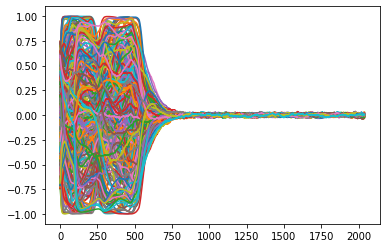

In [32]:
plt.plot(pre_training)
clear_output()

In [33]:
####################
# Training reccurent weight
####################

nb_learning_trials_rec = len(X_input_rc)


for i in tqdm(range(nb_learning_trials_rec)):
    
    print('Learning trial recurrent', i+1)

    impulse = X_input_rc[i]
    
    target_rc = X_target_rc[i]
    
    print(np.shape(impulse),np.shape(target_rc))
    
    stop = np.shape(X_input_rc[i])[0]
    
    _, _ = net.simulate(stimulus=impulse,
                        trajectory=target_rc,
                        learn_start= 0,
                        learn_stop=stop)
    
    clear_output()


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [09:27<00:00, 18.91s/it]


Récupération des données après entrainement et affichage

100%|███████████████████████████████████████████████████████████████████████████| 2040/2040 [00:00<00:00, 11754.42it/s]


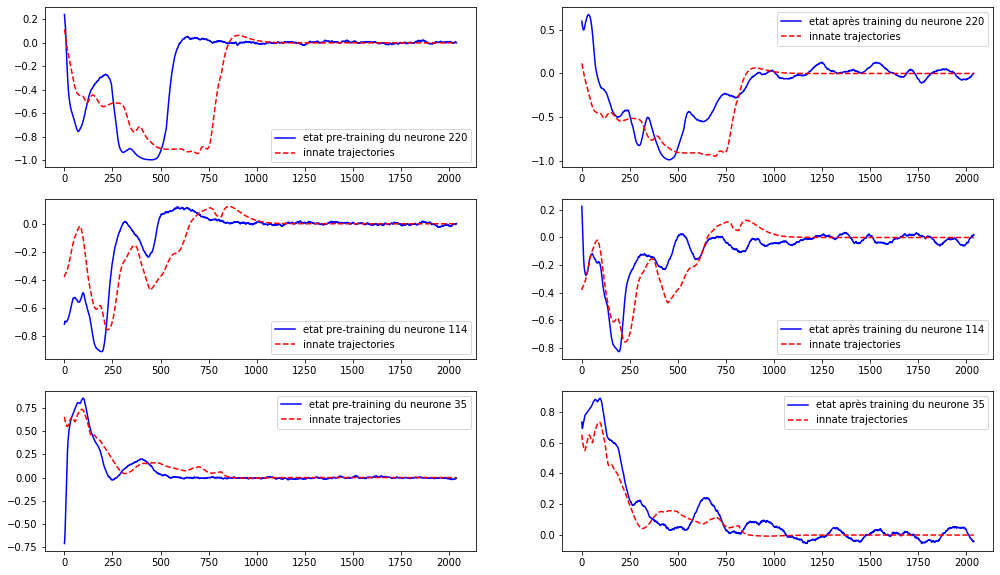

In [34]:
post_training, _ = net.simulate(stimulus = X_input_rc[0])

post_training = np.squeeze(post_training,axis =2)

fig,ax = plt.subplots(figsize=(17,10),nrows = 3,ncols=2)

for i in range(3):
    neuron = randint(1,N)
    ax[i,0].plot(pre_training[:,neuron],"b",label = "etat pre-training du neurone " + str(neuron))
    ax[i,0].plot(pre_training_target[:,neuron],'--r',label = "innate trajectories")
    ax[i,0].legend()
    
    ax[i,1].plot(post_training[:,neuron],"b",label = "etat après training du neurone " + str(neuron))
    ax[i,1].plot(pre_training_target[:,neuron],'--r',label = "innate trajectories")
    ax[i,1].legend()

Affichage des valeurs propres

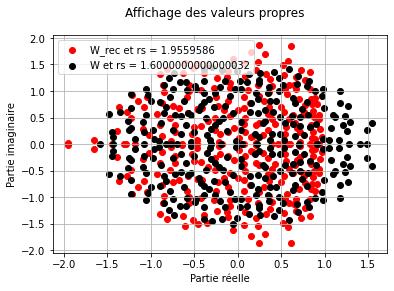

In [49]:
A = getattr(net,"W_rec")
a.eigein_value(A,W,"W_rec","W")


Entrainement de la sortie

Récupération des données 

In [36]:
X_input_out = []
X_target_out = []
for indS in [1] : 
    for indU in range(1,4):
        for indD in range(10):
            #ajout de l'input
            input_out = np.expand_dims(np.transpose(c.entrance_cocleogram(indS, indU, indD,data,transcription)),axis = 2)
            
            X_input_out.append(input_out)
            
            #ajout de la target
            target_out = np.expand_dims(c.target_xyz(indS, indU, indD,data,transcription),axis =2)
            
            X_target_out.append(target_out)
            
            print(np.shape(input_out),np.shape(target_out))

(2040, 12, 1) (2040, 3, 1)
(1231, 12, 1) (1231, 3, 1)
(1680, 12, 1) (1680, 3, 1)
(2076, 12, 1) (2076, 3, 1)
(1602, 12, 1) (1602, 3, 1)
(2311, 12, 1) (2311, 3, 1)
(2516, 12, 1) (2516, 3, 1)
(1903, 12, 1) (1903, 3, 1)
(1990, 12, 1) (1990, 3, 1)
(2175, 12, 1) (2175, 3, 1)
(2040, 12, 1) (2040, 3, 1)
(1231, 12, 1) (1231, 3, 1)
(1680, 12, 1) (1680, 3, 1)
(2076, 12, 1) (2076, 3, 1)
(1602, 12, 1) (1602, 3, 1)
(2311, 12, 1) (2311, 3, 1)
(2516, 12, 1) (2516, 3, 1)
(1903, 12, 1) (1903, 3, 1)
(1990, 12, 1) (1990, 3, 1)
(2175, 12, 1) (2175, 3, 1)
(2040, 12, 1) (2040, 3, 1)
(1231, 12, 1) (1231, 3, 1)
(1680, 12, 1) (1680, 3, 1)
(2076, 12, 1) (2076, 3, 1)
(1602, 12, 1) (1602, 3, 1)
(2311, 12, 1) (2311, 3, 1)
(2516, 12, 1) (2516, 3, 1)
(1903, 12, 1) (1903, 3, 1)
(1990, 12, 1) (1990, 3, 1)
(2175, 12, 1) (2175, 3, 1)


In [37]:
np.shape(target_out[0,:,:])

(3, 1)

Entrainement

In [38]:
####################
# Training output weight
####################

nb_learning_trials_readout = len(X_input_out)


for i in tqdm(range(nb_learning_trials_readout)):
    
    print('Learning trial readout', i+1)
    
    stop = np.shape(X_input_out[i])[0]
    
    impulse = X_input_out[i]
    
    target = X_target_out[i]
    
    _, _ = net.simulate(stimulus=impulse,
                        trajectory=target,
                        learn_start=0,
                        learn_stop=stop,
                        learn_readout=True)
    
    
    clear_output()
    
plt.plot

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:27<00:00,  1.10it/s]


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

Test du réservoir 

In [39]:
#Test du réservoir

#Récupération d'un cocléogramme utilisé durant l'entrainement
indS,indU,indD = 1,3,6
X_test = np.transpose(c.entrance_cocleogram(indS,indU,indD,data,transcription))
X_test = np.expand_dims(X_test,axis =2)


#On fait trner le réservoir
X_state,X_output = net.simulate(stimulus = X_test)

X_state = np.squeeze(X_state,axis =2)
X_output = np.squeeze(X_output,axis =2)

#récupération de l'erreur commise sur la trajectoire d'un chiffre
erreur= c.error(X_output,indS,indU,indD,data,transcription)


100%|███████████████████████████████████████████████████████████████████████████| 2516/2516 [00:00<00:00, 11584.78it/s]


1


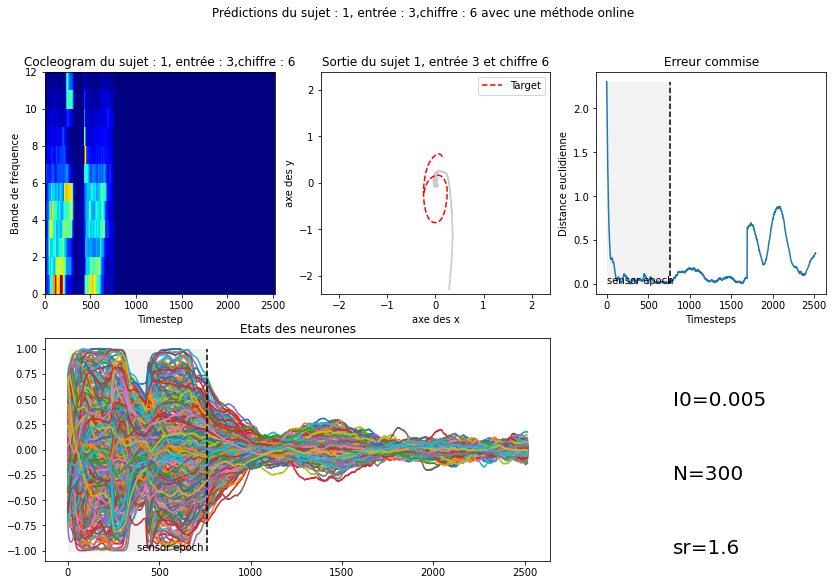

In [40]:
a.affiche(X_output,indS,indU,indD,data,transcription,X_state,erreur,mode = "online",sr = sr,N=N,I0 = I0)

Affichage pour plusieurs chiffres

In [41]:
#Récupération de l'entrée et du sujet
indS,indU= 1,3

chiffre_pred_rc=[]

#On calcule la prédictions pour chacun des 10 chiffres 
for i in range(10):
    
    #Récupération de l'entrée
    X_test_rc = np.expand_dims(c.entrance_cocleogram(indS,indU,i,data,transcription).T,axis=2)
    
    #On fait tourner le réservoir
    _,X_output = net.simulate(X_test_rc)
    
    X_output = np.squeeze(X_output,axis =2)
    
    #On ajoute à la liste
    chiffre_pred_rc.append(X_output)


100%|███████████████████████████████████████████████████████████████████████████| 2175/2175 [00:00<00:00, 10115.26it/s]


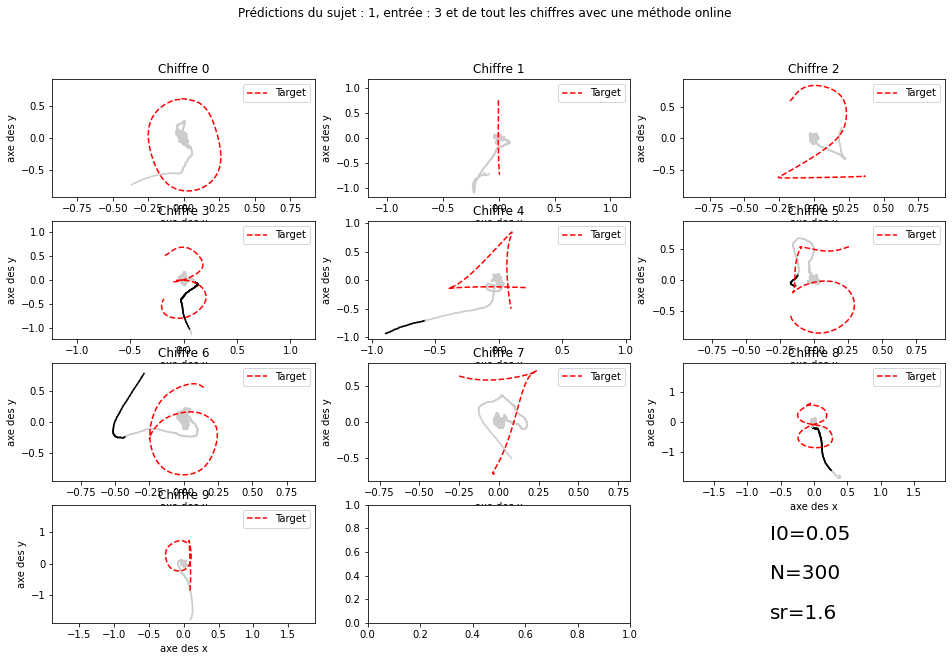

In [42]:
a.affiche_chiffre(chiffre_pred_rc,indS,indU,data,transcription,mode="online",sr = sr,N=N,I0 = 0.05)